***** importing dependencies *****

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

***** importing dataset *****

In [2]:
deliv_df = pd.read_csv('deliverytimehistory.txt')
deliv_df.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Type_of_order,Type_of_vehicle,Time_taken(min)
0,4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,Snack,motorcycle,24
1,B379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,Snack,scooter,33
2,5D6D,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,Drinks,motorcycle,26
3,7A6A,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,Buffet,motorcycle,21
4,70A2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,Snack,scooter,30


***** pre-processing dataset *****

* We start by dropping the ID column since it doesn't contain any useful information

In [3]:
# dropping the ID column
deliv_df.drop('ID', axis=1, inplace=True)
deliv_df.head()

,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Type_of_order,Type_of_vehicle,Time_taken(min)
0,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,Snack,motorcycle,24
1,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,Snack,scooter,33
2,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,Drinks,motorcycle,26
3,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,Buffet,motorcycle,21
4,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,Snack,scooter,30


* Next we add a column for distance as we did during EDA. We employ the geopy library that can calculate accurate distances given latitudes and longitudes

In [4]:
from geopy.distance import geodesic

# Calculate the distance between restaurant and delivery location
deliv_df['Distance'] = deliv_df.apply(lambda row: geodesic((row['Restaurant_latitude'], row['Restaurant_longitude']),
                                                            (row['Delivery_location_latitude'], row['Delivery_location_longitude'])).kilometers, axis=1)
deliv_df.head()

,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Type_of_order,Type_of_vehicle,Time_taken(min),Distance
0,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,Snack,motorcycle,24,3.020737
1,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,Snack,scooter,33,20.143737
2,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,Drinks,motorcycle,26,1.549693
3,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,Buffet,motorcycle,21,7.774497
4,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,Snack,scooter,30,6.197898


* Now we need to handle the non numerical columns
    - Using the categorical features as is would not be suitable since the Deep Learning Model would not be able to interpret them properly
    - We will use one hot encoding for the Type_of_order and Type_of_vehicle because they have low cardinality and are not ordered in any way
    - The Delivery_person_ID is somewhat more complicated since it has high cardinality so one hot encoding would create a highly dimensional and sparse feature space
    - Consequently, we will use feature hashing in this case

In [5]:
# Perform one-hot encoding on categorical columns
deliv_df_encoded = pd.get_dummies(deliv_df, columns=["Type_of_vehicle", "Type_of_order"])

# Display the encoded DataFrame
deliv_df_encoded.head()


,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Time_taken(min),Distance,Type_of_vehicle_bicycle,Type_of_vehicle_electric_scooter,Type_of_vehicle_motorcycle,Type_of_vehicle_scooter,Type_of_order_Buffet,Type_of_order_Drinks,Type_of_order_Meal,Type_of_order_Snack
0,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,24,3.020737,0,0,1,0,0,0,0,1
1,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,33,20.143737,0,0,0,1,0,0,0,1
2,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,26,1.549693,0,0,1,0,0,1,0,0
3,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,21,7.774497,0,0,1,0,1,0,0,0
4,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,30,6.197898,0,0,0,1,0,0,0,1


processed_df = deliv_df_encoded.copy()

In [6]:
from sklearn.feature_extraction import FeatureHasher

# Create an instance of FeatureHasher
hasher = FeatureHasher(n_features=4, input_type='string')

# Extract the Delivery_person_ID column as a list of strings
delivery_person_ids = deliv_df_encoded['Delivery_person_ID'].astype(str).tolist()

# Apply feature hashing to the Delivery_person_ID column
hashed_features = hasher.transform(delivery_person_ids)

# Convert the hashed features to a NumPy array
hashed_features_array = hashed_features.toarray()

# Create a new DataFrame with the hashed features
hashed_df = pd.DataFrame(hashed_features_array, columns=['hashed_feature_{}'.format(i) for i in range(4)])

# Drop the original Delivery_person_ID column
deliv_df_encoded.drop('Delivery_person_ID', axis=1, inplace=True)

# Concatenate the hashed DataFrame with the original DataFrame
processed_df = pd.concat([deliv_df_encoded, hashed_df], axis=1)
processed_df.head()


,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Time_taken(min),Distance,Type_of_vehicle_bicycle,Type_of_vehicle_electric_scooter,Type_of_vehicle_motorcycle,Type_of_vehicle_scooter,Type_of_order_Buffet,Type_of_order_Drinks,Type_of_order_Meal,Type_of_order_Snack,hashed_feature_0,hashed_feature_1,hashed_feature_2,hashed_feature_3
0,37,4.9,22.745049,75.892471,22.765049,75.912471,24,3.020737,0,0,1,0,0,0,0,1,0.0,-2.0,4.0,2.0
1,34,4.5,12.913041,77.683237,13.043041,77.813237,33,20.143737,0,0,0,1,0,0,0,1,-1.0,-2.0,1.0,2.0
2,23,4.4,12.914264,77.678400,12.924264,77.688400,26,1.549693,0,0,1,0,0,1,0,0,-1.0,-1.0,1.0,1.0
3,38,4.7,11.003669,76.976494,11.053669,77.026494,21,7.774497,0,0,1,0,1,0,0,0,0.0,-3.0,3.0,3.0
4,32,4.6,12.972793,80.249982,13.012793,80.289982,30,6.197898,0,0,0,1,0,0,0,1,-1.0,-3.0,1.0,3.0


* Finally, we have to split our dataset into the train and test set

In [7]:
from sklearn.model_selection import train_test_split

# Separate the features and target variable
X = processed_df.drop('Time_taken(min)', axis=1)
y = processed_df['Time_taken(min)']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

***** training the model *****

* We will use Pytorch to train the model

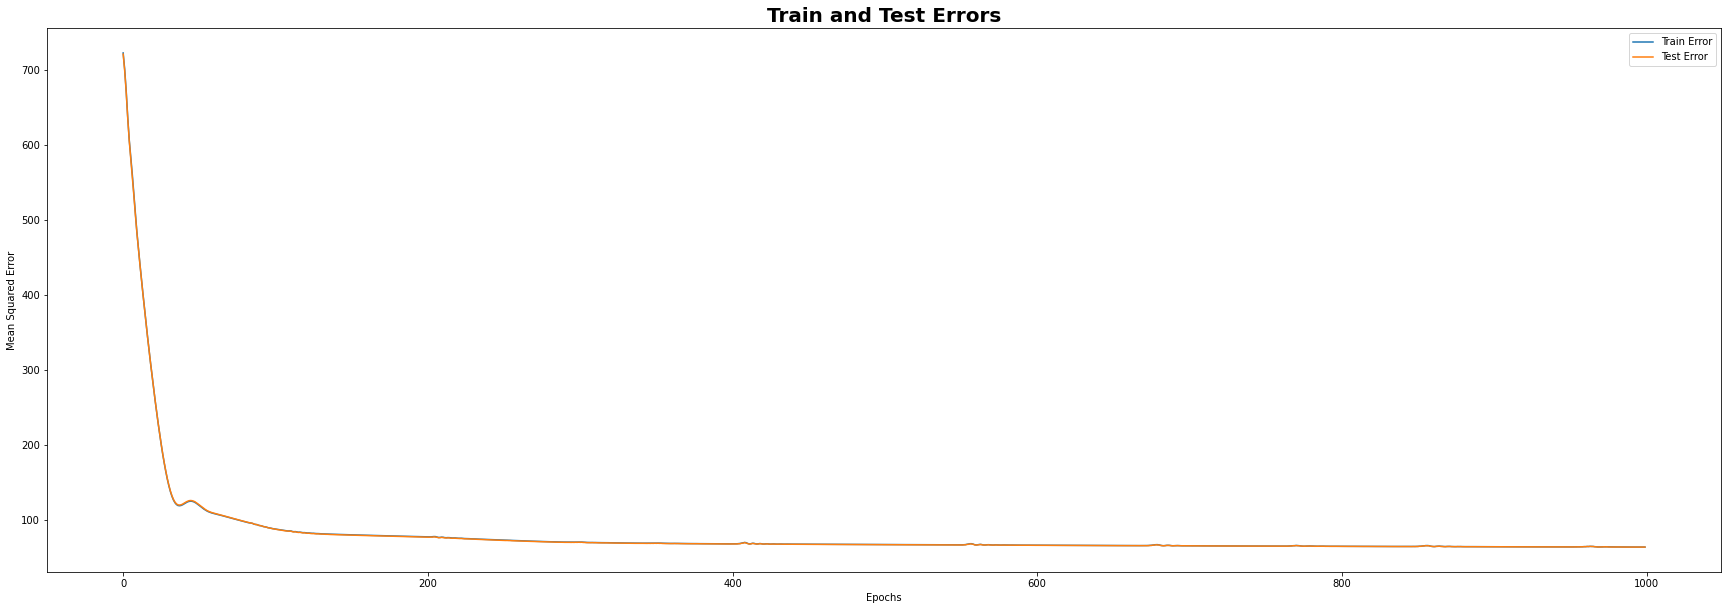

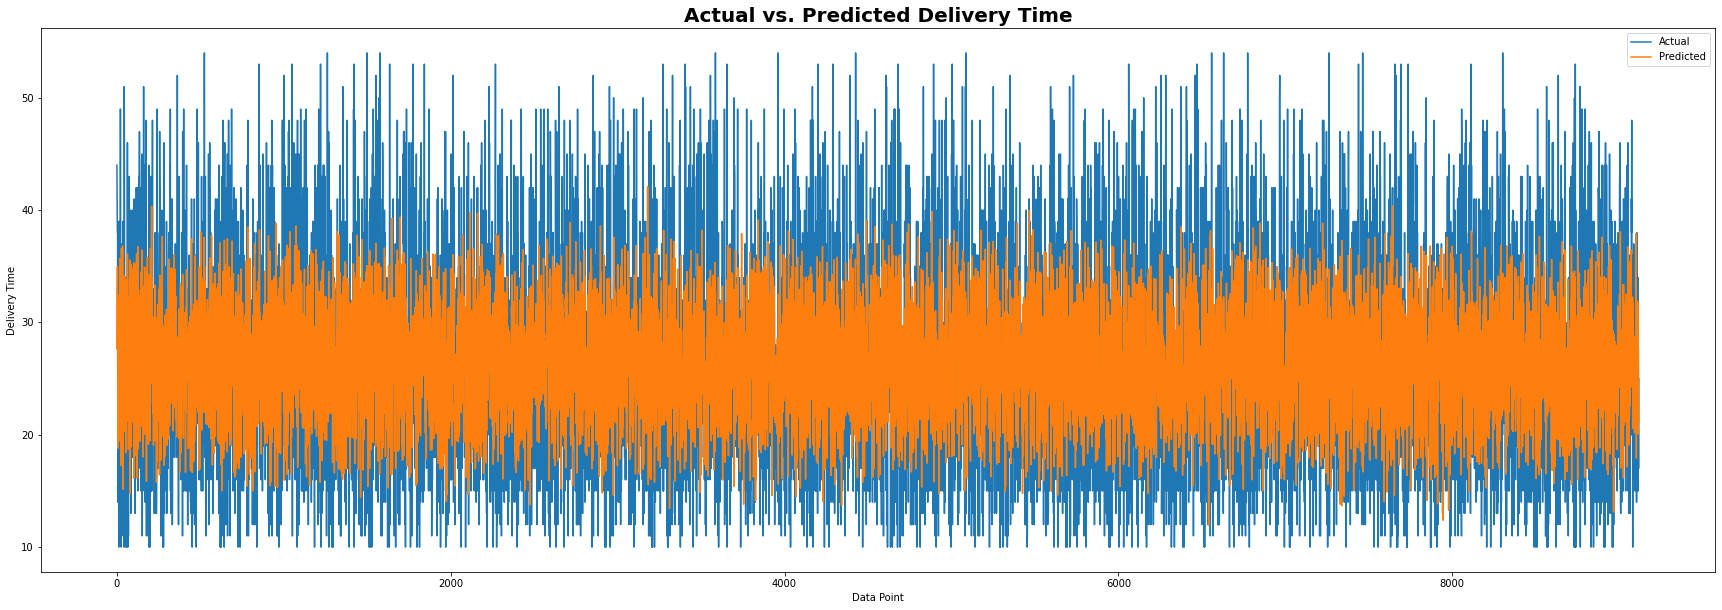

RMSE: 7.9987660922452095


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error

# Check if CUDA is available and use it if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the model architecture
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Create an instance of the model
model = NeuralNetwork(input_size=X_train.shape[1]).to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert the data to PyTorch tensors and move to the device
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)

# Lists to store the training and testing errors
train_errors = []
test_errors = []

# Train the model with early stopping criterion
best_loss = float('inf')
patience = 100  # Number of epochs to wait for improvement
early_stop_counter = 0
num_epochs = 1000

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs.squeeze(), y_train_tensor)
    loss.backward()
    optimizer.step()

    # Calculate training error
    model.eval()
    with torch.no_grad():
        train_predictions = model(X_train_tensor).squeeze()
        train_error = mean_squared_error(y_train_tensor.cpu(), train_predictions.cpu())

    # Calculate testing error
    model.eval()
    with torch.no_grad():
        test_predictions = model(X_test_tensor).squeeze()
        test_error = mean_squared_error(y_test, test_predictions.cpu())

    # Record errors
    train_errors.append(train_error)
    test_errors.append(test_error)

    # Check early stopping criterion
    if test_error < best_loss:
        best_loss = test_error
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f'Early stopping at epoch {epoch} due to no improvement.')
            break

# Calculate RMSE
rmse = np.sqrt(test_errors[-1])

# Plot train and test errors
num_data_points = len(train_errors)
fig_size = (20, 10) if num_data_points <= 100 else (30, 10) if num_data_points <= 1000 else (40, 10)

plt.rcParams['figure.figsize'] = fig_size
plt.plot(range(len(train_errors)), train_errors, label='Train Error')
plt.plot(range(len(test_errors)), test_errors, label='Test Error')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('Train and Test Errors', fontsize=20, weight='bold')
plt.show()

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)
    y_pred = y_pred_tensor.squeeze().cpu().numpy()

# Plot y_test and y_pred values
fig, ax = plt.subplots()
ax.plot(range(len(y_test)), y_test, label='Actual')
ax.plot(range(len(y_pred)), y_pred, label='Predicted')
ax.set_xlabel('Data Point')
ax.set_ylabel('Delivery Time')
ax.set_title('Actual vs. Predicted Delivery Time', fontsize=20, weight='bold')
ax.legend()
plt.show()

print("RMSE:", rmse)

* After training the model and evaluating it, we get a low RMSE of 8.
    - However, since the model still makes false predictions quite a lot and there is no uncertainty quantification
    - This makes the model less useful for decision making and, if it were deployed on an e-commerce platform, less reliably informative to customers
    - This is the problem we will attempt to solve with Conformalized Quantile Regression

### legacy code - to be deleted later

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
from scipy.stats import norm

# Check if CUDA is available and use it if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the model architecture
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Create an instance of the model
model = NeuralNetwork(input_size=X_train.shape[1]).to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Convert the data to PyTorch tensors and move to the device
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)

# Lists to store the training and testing errors
train_errors = []
test_errors = []

# Train the model with early stopping criterion
best_loss = float('inf')
patience = 100  # Number of epochs to wait for improvement
early_stop_counter = 0
num_epochs = 10000

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs.squeeze(), y_train_tensor)
    loss.backward()
    optimizer.step()

    # Calculate training error
    model.eval()
    with torch.no_grad():
        train_predictions = model(X_train_tensor).squeeze()
        train_error = mean_squared_error(y_train_tensor.cpu(), train_predictions.cpu())

    # Calculate testing error
    model.eval()
    with torch.no_grad():
        test_predictions = model(X_test_tensor).squeeze()
        test_error = mean_squared_error(y_test, test_predictions.cpu())

    # Record errors
    train_errors.append(train_error)
    test_errors.append(test_error)

    # Check early stopping criterion
    if test_error < best_loss:
        best_loss = test_error
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f'Early stopping at epoch {epoch} due to no improvement.')
            break

# Calculate RMSE
rmse = np.sqrt(test_errors[-1])

# Calculate CQR
alpha = 0.1  # Miscoverage rate
lower_quantile = alpha / 2
upper_quantile = 1 - alpha / 2

# Calculate lower and upper quantiles
with torch.no_grad():
    quantiles = model(X_test_tensor).squeeze().cpu().numpy()
    lower_bound = np.percentile(quantiles, lower_quantile * 100, axis=0)
    upper_bound = np.percentile(quantiles, upper_quantile * 100, axis=0)

# Measure correctness of predictions
correct_predictions = np.sum((y_test >= lower_bound) & (y_test <= upper_bound))
wrong_predictions = np.sum((y_test < lower_bound) | (y_test > upper_bound))
percentage_correct = correct_predictions / len(y_test) * 100

# Calculate length of predicted ranges
range_lengths = upper_bound - lower_bound
avg_range_length = np.mean(range_lengths)
max_range_length = np.max(range_lengths)
min_range_length = np.min(range_lengths)

# Plot train and test errors
num_data_points = len(train_errors)
fig_size = (20, 10) if num_data_points <= 100 else (30, 10) if num_data_points <= 1000 else (40, 10)

plt.rcParams['figure.figsize'] = fig_size
plt.plot(range(len(train_errors)), train_errors, label='Train Error')
plt.plot(range(len(test_errors)), test_errors, label='Test Error')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('Train and Test Errors', fontsize=20, weight='bold')
plt.show()

# Print results
print("RMSE:", rmse)
print("Percentage of Correct Predictions:", percentage_correct)
print("Average Range Length:", avg_range_length)
print("Maximum Range Length:", max_range_length)
print("Minimum Range Length:", min_range_length)

* Training the model with XGBoost to compare the performance

import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Create the XGBoost model and set number of epochs
model = xgb.XGBRegressor(objective='reg:squarederror')

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics (e.g., RMSE)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE:", rmse)